In [19]:
import os
import sys
import glob
import torch.nn.functional as F
import numpy
import matplotlib.pyplot as plt

from scipy.stats import ttest_ind

sys.path.append('../')

from utils.uniprot_loader import *
from utils.annoy_helper import *

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cuda:0'

In [4]:
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)

In [5]:
train_data, dev_data = get_uniprot_data('../uniprot_data_prep')

In [6]:
p1train = set([x[0] for x in train_data])
p2train = set([x[1] for x in train_data])
p1dev = set([x[0] for x in dev_data])
p2dev = set([x[1] for x in dev_data])
trainset = p1train.union(p2train)
dev_data_cleaned = [data for data in dev_data if data[0] not in trainset and data[1] not in trainset]

In [7]:
model = get_model('siamese-biobert-v1-1-ep-1-Dec-22-2020-with-heuris-2', device=device)

## Inspect Vector Similarity

In [8]:
def compare_similarity(model, en1, en2):
    v1 = model.encode(en1, convert_to_tensor=True).view(1,-1)
    v2 = model.encode(en2, convert_to_tensor=True).view(1,-1)
    sim = F.cosine_similarity(v1,v2)
    return sim

In [52]:
pos_sim = []
neg_sim = []
for idx, data in enumerate(train_data[::100]):
    if idx % 100 == 0:
        print(idx*100/len(train_data[::100]), " %")
    name1, name2, score = data
    sim_score = compare_similarity(model, name1, name2).item()
    if score == 1:
        pos_sim.append(sim_score)
    elif score == 0:
        neg_sim.append(sim_score)

0.0  %
0.9660902328277461  %
1.9321804656554922  %
2.8982706984832385  %
3.8643609313109843  %
4.83045116413873  %
5.796541396966477  %
6.762631629794223  %
7.728721862621969  %
8.694812095449715  %
9.66090232827746  %
10.626992561105208  %
11.593082793932954  %
12.5591730267607  %
13.525263259588446  %
14.491353492416192  %
15.457443725243937  %
16.423533958071683  %
17.38962419089943  %
18.355714423727175  %
19.32180465655492  %
20.287894889382667  %
21.253985122210416  %
22.220075355038162  %
23.186165587865908  %
24.152255820693654  %
25.1183460535214  %
26.084436286349145  %
27.05052651917689  %
28.016616752004637  %
28.982706984832383  %
29.94879721766013  %
30.914887450487875  %
31.88097768331562  %
32.84706791614337  %
33.81315814897111  %
34.77924838179886  %
35.745338614626604  %
36.71142884745435  %
37.677519080282096  %
38.64360931310984  %
39.60969954593759  %
40.57578977876533  %
41.54188001159308  %
42.50797024442083  %
43.47406047724858  %
44.440150710076324  %
45.40624

In [53]:
pos_sim = np.asarray(pos_sim,dtype='float32').flatten()
neg_sim = np.asarray(neg_sim,dtype='float32').flatten()

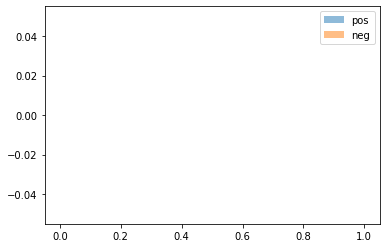

In [20]:
# bins = numpy.linspace(0, 1, 100)
bins = 10

plt.hist(pos_sim, bins, alpha=0.5, label='pos')
plt.hist(neg_sim, bins, alpha=0.5, label='neg')
plt.legend(loc='upper right')
plt.show()

In [57]:
stat, p = ttest_ind(pos_sim, neg_sim)
print('stat=%.3f, p=%.9f' % (stat, p))
if p > 0.05:
    print('Probably the same distribution')
else:
    print('Probably different distributions')

stat=413.839, p=0.000000000
Probably different distributions


In [9]:
pos_sim_dev = []
neg_sim_dev = []
for idx, data in enumerate(dev_data_cleaned[::2]):
    name1, name2, score = data
    if idx % 100 == 0:
        print(idx*100/len(dev_data_cleaned[::2]), " %")
    sim_score = compare_similarity(model, name1, name2).item()
    if score == 1:
        pos_sim_dev.append(sim_score)
    elif score == 0:
        neg_sim_dev.append(sim_score)

0.0  %
0.9853187506158242  %
1.9706375012316484  %
2.9559562518474727  %
3.9412750024632968  %
4.926593753079121  %
5.911912503694945  %
6.897231254310769  %
7.8825500049265935  %
8.867868755542418  %
9.853187506158243  %
10.838506256774066  %
11.82382500738989  %
12.809143758005716  %
13.794462508621539  %
14.779781259237364  %
15.765100009853187  %
16.75041876046901  %
17.735737511084835  %
18.72105626170066  %
19.706375012316485  %
20.69169376293231  %
21.67701251354813  %
22.662331264163956  %
23.64765001477978  %
24.632968765395606  %
25.61828751601143  %
26.603606266627253  %
27.588925017243078  %
28.574243767858903  %
29.559562518474728  %
30.54488126909055  %
31.530200019706374  %
32.5155187703222  %
33.50083752093802  %
34.486156271553845  %
35.47147502216967  %
36.456793772785495  %
37.44211252340132  %
38.427431274017145  %
39.41275002463297  %
40.398068775248795  %
41.38338752586462  %
42.36870627648044  %
43.35402502709626  %
44.33934377771209  %
45.32466252832791  %
46.30

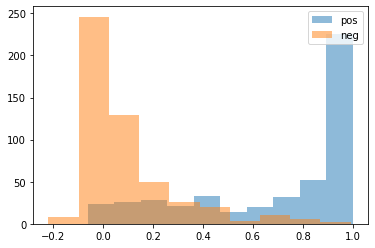

In [12]:
# bins = numpy.linspace(0, 1, 100)
bins = 10

plt.hist(pos_sim_dev, bins, alpha=0.5, label='pos')
plt.hist(np.random.choice(neg_sim_dev, 500, replace=False), bins, alpha=0.5, label='neg')
plt.legend(loc='upper right')
plt.show()

In [58]:
stat, p = ttest_ind(pos_sim_dev, neg_sim_dev)
print('stat=%.3f, p=%.9f' % (stat, p))
if p > 0.05:
    print('Probably the same distribution')
else:
    print('Probably different distributions')

stat=63.337, p=0.000000000
Probably different distributions


In [65]:
c = 0
for score in pos_sim_dev:
    c = c + 1 if score >= 0.8 else c
print(c, c/len(pos_sim_dev))

271 0.5705263157894737


## Hard Negative Inspection

In [1]:
base_model_name = 'siamese-biobert-v1-1-ep-1-Dec-27-2020-with-heuris-hard-neg-'
hard_neg_file = glob.glob('./hard_neg/*')

In [45]:
def get_score_dist(model, dataset):
    pos_sim = []
    neg_sim = []
    for idx, data in enumerate(dataset):
        name1, name2, score = data
        if idx % 100 == 0:
            print(idx*100/len(dataset), " %")
        sim_score = compare_similarity(model, name1, name2).item()
        if score == 1:
            pos_sim.append(sim_score)
        elif score == 0:
            neg_sim.append(sim_score)
    return np.array(pos_sim, dtype='float32'), np.array(neg_sim, dtype='float32')

In [48]:
all_pos = []
all_neg = []
for i in range(0,9,2):
    print("ROUND: ", i+1)
    model_name = base_model_name + str(i)
    model = get_model(model_name)
    pos_sim, neg_sim = get_score_dist(model, dev_data_cleaned)
    all_pos.append(pos_sim)
    all_neg.append(neg_sim)

ROUND:  1
0.0  %
0.4926836478297285  %
0.985367295659457  %
1.4780509434891855  %
1.970734591318914  %
2.4634182391486426  %
2.956101886978371  %
3.4487855348080996  %
3.941469182637828  %
4.434152830467557  %
4.926836478297285  %
5.419520126127014  %
5.912203773956742  %
6.404887421786471  %
6.897571069616199  %
7.390254717445928  %
7.882938365275656  %
8.375622013105385  %
8.868305660935114  %
9.360989308764841  %
9.85367295659457  %
10.3463566044243  %
10.839040252254028  %
11.331723900083757  %
11.824407547913484  %
12.317091195743213  %
12.809774843572942  %
13.302458491402671  %
13.795142139232398  %
14.287825787062127  %
14.780509434891856  %
15.273193082721585  %
15.765876730551312  %
16.25856037838104  %
16.75124402621077  %
17.2439276740405  %
17.736611321870228  %
18.229294969699957  %
18.721978617529683  %
19.21466226535941  %
19.70734591318914  %
20.20002956101887  %
20.6927132088486  %
21.185396856678327  %
21.678080504508056  %
22.170764152337785  %
22.663447800167514  %

91.14647484849978  %
91.6391584963295  %
92.13184214415924  %
92.62452579198896  %
93.1172094398187  %
93.60989308764842  %
94.10257673547815  %
94.59526038330787  %
95.08794403113761  %
95.58062767896733  %
96.07331132679707  %
96.56599497462679  %
97.05867862245653  %
97.55136227028625  %
98.04404591811598  %
98.5367295659457  %
99.02941321377544  %
99.52209686160516  %
ROUND:  5
0.0  %
0.4926836478297285  %
0.985367295659457  %
1.4780509434891855  %
1.970734591318914  %
2.4634182391486426  %
2.956101886978371  %
3.4487855348080996  %
3.941469182637828  %
4.434152830467557  %
4.926836478297285  %
5.419520126127014  %
5.912203773956742  %
6.404887421786471  %
6.897571069616199  %
7.390254717445928  %
7.882938365275656  %
8.375622013105385  %
8.868305660935114  %
9.360989308764841  %
9.85367295659457  %
10.3463566044243  %
10.839040252254028  %
11.331723900083757  %
11.824407547913484  %
12.317091195743213  %
12.809774843572942  %
13.302458491402671  %
13.795142139232398  %
14.28782578

82.27816918756467  %
82.7708528353944  %
83.26353648322412  %
83.75622013105385  %
84.24890377888357  %
84.74158742671331  %
85.23427107454303  %
85.72695472237277  %
86.21963837020249  %
86.71232201803222  %
87.20500566586195  %
87.69768931369168  %
88.1903729615214  %
88.68305660935114  %
89.17574025718086  %
89.6684239050106  %
90.16110755284032  %
90.65379120067006  %
91.14647484849978  %
91.6391584963295  %
92.13184214415924  %
92.62452579198896  %
93.1172094398187  %
93.60989308764842  %
94.10257673547815  %
94.59526038330787  %
95.08794403113761  %
95.58062767896733  %
96.07331132679707  %
96.56599497462679  %
97.05867862245653  %
97.55136227028625  %
98.04404591811598  %
98.5367295659457  %
99.02941321377544  %
99.52209686160516  %
ROUND:  9
0.0  %
0.4926836478297285  %
0.985367295659457  %
1.4780509434891855  %
1.970734591318914  %
2.4634182391486426  %
2.956101886978371  %
3.4487855348080996  %
3.941469182637828  %
4.434152830467557  %
4.926836478297285  %
5.419520126127014  

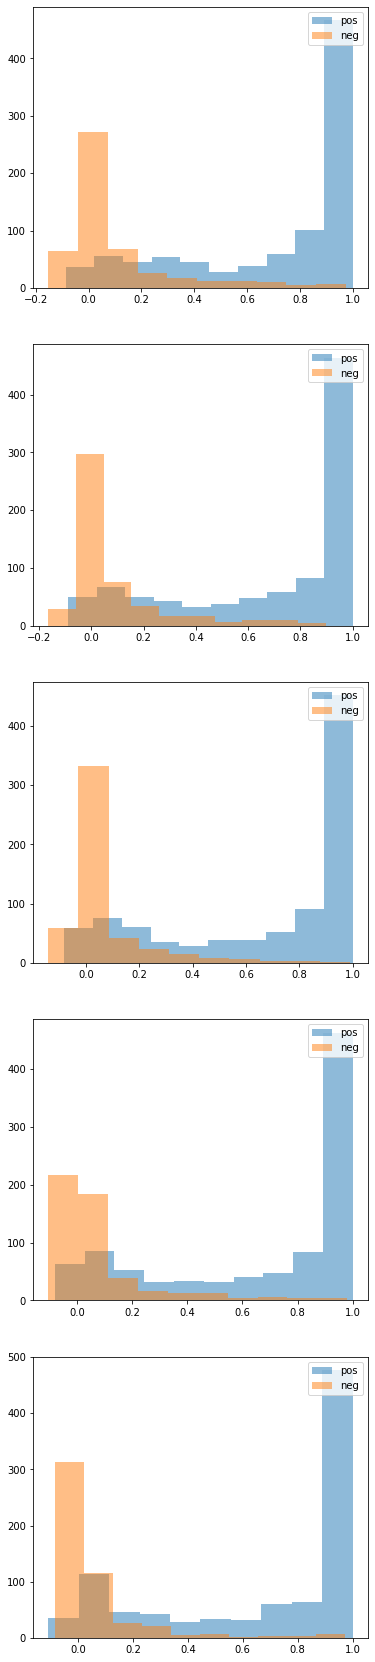

In [50]:
fig, axs = plt.subplots(5,1,figsize=(6,30))

bins = 10
for i in range(5):
    axs[i].hist(all_pos[i], bins, alpha=0.5, label='pos')
    axs[i].hist(np.random.choice(all_neg[i], 500, replace=False), bins, alpha=0.5, label='neg')
    axs[i].legend(loc='upper right')
pyplot.show()

In [55]:
for i in range(5):
    c = 0
    for score in all_pos[i]:
        c = c + 1 if score >= 0.8 else c
    print(c, len(all_pos[i]), c/len(all_pos[i]))

556 932 0.5965665236051502
534 932 0.572961373390558
532 932 0.5708154506437768
536 932 0.575107296137339
525 932 0.5633047210300429


### Hard Negative Example

In [67]:
df_list = []
for f in glob.glob('./hard_neg/*'):
    df = pd.read_csv(f, delimiter='\t')
    df_list.append(df)

In [75]:
pd.set_option('display.max_rows', 50)
pd.set_option('display.min_rows', 50)

In [76]:
display(df_list[0])

,name1,name2
0,hVps34,PDHK4
1,hVps34,Phosphoinositide 3-kinase regulatory subunit 6
2,hVps34,MAPKAP-K5
3,hVps34,PFK-L
4,hVps34,Phosphorylase kinase subunit gamma-1
5,hVps34,PHKG
6,hVps34,AGK
7,hVps34,Phosphoinositide 3-kinase gamma adapter protei...
8,hVps34,MAP kinase-interacting serine/threonine-protei...
9,hVps34,MARKK
